In [6]:
from astropy.io import fits
import numpy as np

In [7]:
#Matplotlib configuration
from matplotlib import pyplot as plt

#A4 tufte layout paper figure sizes
MARGIN_FIG = lambda scale: (1.99, 1.99*scale)
MAIN_FIG = lambda scale: (4.18, 4.18*scale)
FULL_FIG = lambda scale: (6.64, 6.64*scale)

#Fontsize configuration
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', family='Fira Code')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#Other matplotlib configuration
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.autolayout'] = True
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1
plt.rcParams["savefig.bbox"] = 'tight'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Fira Code'
plt.rcParams['mathtext.it'] = 'Fira Code'
plt.ioff()

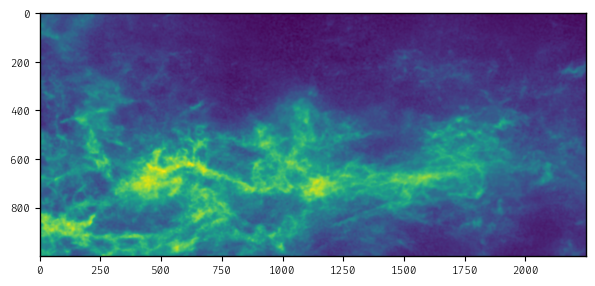

In [8]:
path = "../tmp/full_cube_smoothed.fits"
plane = fits.open(path)[0].data
plt.imshow(plane[182])
plt.show()

In [9]:
print(plane.shape)

(272, 1000, 2250)


In [10]:
#plot van de integrated density vs snelheid
N_CHANNELS = 272
V_STEP = -0.82446
V_REF = -60

#snelheid is TOV zon
v = np.linspace(0, V_STEP*N_CHANNELS, num=N_CHANNELS)
v = v - (v[145] - V_REF)

#gegokte begin/eindpunten van spiraalarmen
cygnus = (25, -25)
perseus = (-30, -50)
norma = (-65, -85)

#marginalised velocity
intensity = np.nansum(plane, (1, 2))
del plane

[-150. -125. -100.  -75.  -50.  -25.    0.   25.   50.]


C:\Users\rawol\AppData\Local\Temp\ipykernel_20228\2087626685.py:33: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


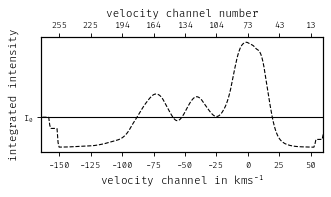

In [11]:
#make plot
fig = plt.figure(figsize=MAIN_FIG(0.6), dpi=80)
ax1 = fig.add_subplot(111)
ax1.plot(v, intensity, color='black', linestyle='--')

#zero axis
plt.axhline(0, color='black')
ax1.set_yticks([0], labels=['$I_0$'])

#arms
ax1.set_xlim(np.min(v), np.max(v))
ax1.set_xlabel("velocity channel in $kms^{-1}$")
ax1.set_ylabel("integrated intensity")

chans = np.arange(1, N_CHANNELS + 1)
def get_chnl(velocity):
  dv = abs(v - velocity)
  return f'{chans[np.where(dv == min(dv))][0]}'

x_ticks = ax1.get_xticks()[1:-1]
print(x_ticks)

#second axis
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(x_ticks, labels=[get_chnl(v) for v in x_ticks])
ax2.set_xlabel('velocity channel number')

#fix first axis?
ax1.set_xticks(x_ticks)

fig.savefig('../figs/integrated_intensity.pdf', transparent=True, bbox_inches="tight", pad_inches=0.05)
fig.show()

In [12]:
#idee: fit gaussische verdelignen aan de pieken?
from scipy.optimize import curve_fit

def gauss(x, *p):
  A, mu, sigma = p
  return A*np.exp(-(x-mu)**2/(2.*sigma**2))

#make guesses for the arms
p0_cygnus = [2.3e8, 10, 25]
p0_perseus = [1e8, -40, 10]
p0_norma = [2e8, -75, 10]

#limit v-range for arms
def limit_params(p0, v, I, tune=2):
  mu, sigma = p0[1], p0[2]
  v_lim = np.ma.masked_where((v <= (mu + tune*sigma)) & (v >= (mu - tune*sigma)), v, copy=True)
  I_lim = np.ma.masked_where((v <= (mu + tune*sigma)) & (v >= (mu - tune*sigma)), I, copy=True)
  return v_lim[v_lim.mask], I_lim[I_lim.mask]

v_cygnus, I_cygnus = limit_params(p0_cygnus, v, intensity, tune=1.0)
v_perseus, I_perseus = limit_params(p0_perseus, v, intensity, tune=1.5)
v_norma, I_norma = limit_params(p0_norma, v, intensity)

#fit gaussians
p_cygnus, cov_cygnus = curve_fit(gauss, v_cygnus, I_cygnus, p0=p0_cygnus)
p_perseus, cov_perseus = curve_fit(gauss, v_perseus, I_perseus, p0=p0_perseus)
p_norma, cov_norma = curve_fit(gauss, v_norma, I_norma, p0=p0_norma)

print(f'cygnus = {p_cygnus}\n{cov_cygnus}')
print(f'perseus = {p_perseus}\n{cov_perseus}')
print(f'norma = {p_norma}\n{cov_norma}')

#berekende! begin/eindpunten van spiraalarmen
vr_cygnus = (p_cygnus[1] - 2*p_cygnus[2], p_cygnus[1] + 2*p_cygnus[2])
vr_perseus = (p_perseus[1] - 2*p_perseus[2], p_perseus[1] + 2*p_perseus[2])
vr_norma = (p_norma[1] - 2*p_norma[2], p_norma[1] + 2*p_norma[2])

print(vr_cygnus)
print(vr_perseus)
print(vr_norma)

cygnus = [6.18422284e+06 4.57523443e-01 9.62328630e+00]
[[ 1.01651822e+11  1.33977716e+04 -1.23057271e+05]
 [ 1.33977716e+04  3.49172940e-01 -6.16717558e-02]
 [-1.23057271e+05 -6.16717558e-02  4.15368114e-01]]
perseus = [ 1.57440662e+06 -4.02488372e+01  5.95626103e+00]
[[ 9.52641810e+08  1.13464281e+01 -2.46075598e+03]
 [ 1.13464281e+01  1.81173622e-02 -1.03863793e-04]
 [-2.46075598e+03 -1.03863793e-04  1.87263802e-02]]
norma = [ 1.84392884e+06 -7.34834338e+01  6.46930123e+00]
[[ 1.01657185e+10 -1.96541625e+01 -2.38251150e+04]
 [-1.96541625e+01  1.66744938e-01  1.55471787e-04]
 [-2.38251150e+04  1.55471787e-04  1.67230021e-01]]
(-18.78904916608987, 19.70409605125936)
(-52.16135925994381, -28.33631512370846)
(-86.42203625802011, -60.54483133744173)


C:\Users\rawol\AppData\Local\Temp\ipykernel_20228\2121258885.py:15: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(*vr_cygnus, color='red', alpha=0.2, edgecolor=0.0)
C:\Users\rawol\AppData\Local\Temp\ipykernel_20228\2121258885.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(*vr_perseus, color='blue', alpha=0.2, edgecolor=0.0)
C:\Users\rawol\AppData\Local\Temp\ipykernel_20228\2121258885.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.axvspan(*vr_norma, color='green', alpha=0.2, edgecolor=0.0)


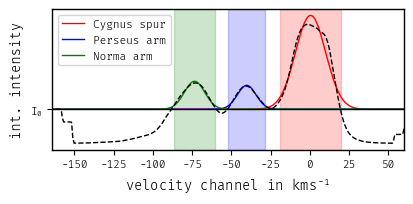

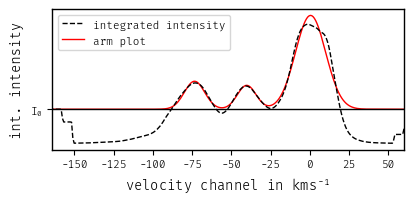

In [13]:
#plot de gausische verdelingen
plt.figure(figsize=MAIN_FIG(0.5))
plt.plot(v, intensity, color='black', linestyle='--', zorder=15)
plt.plot(v, gauss(v, *p_cygnus), color='red', label='Cygnus spur', linestyle='-')
plt.plot(v, gauss(v, *p_perseus), color='blue', label='Perseus arm', linestyle='-')
plt.plot(v, gauss(v, *p_norma), color='green', label='Norma arm', linestyle='-')
plt.legend()
plt.xlim(np.min(v), np.max(v))
plt.xlabel("velocity channel in $kms^{-1}$")
plt.ylabel("int. intensity")
plt.axhline(0, color='black')
plt.yticks([0], labels=['$I_0$'])

#arms
plt.axvspan(*vr_cygnus, color='red', alpha=0.2, edgecolor=0.0)
plt.axvspan(*vr_perseus, color='blue', alpha=0.2, edgecolor=0.0)
plt.axvspan(*vr_norma, color='green', alpha=0.2, edgecolor=0.0)

plt.savefig('../figs/three_gaussians.pdf', transparent=True, bbox_inches="tight", pad_inches=0.05)
plt.show()

#plot all the arms together
combined = gauss(v, *p_cygnus) + gauss(v, *p_perseus) + gauss(v, *p_norma)
plt.figure(figsize=MAIN_FIG(0.5))
plt.plot(v, intensity, color='black', label='integrated intensity', linestyle='--', zorder=15)
plt.plot(v, combined, color='red', label='arm plot')
plt.legend()
plt.xlim(np.min(v), np.max(v))
plt.xlabel("velocity channel in $kms^{-1}$")
plt.ylabel("int. intensity")
plt.axhline(0, color='black')
plt.yticks([0], labels=['$I_0$'])

plt.savefig('../figs/thermal_profile.pdf', transparent=True, bbox_inches="tight", pad_inches=0.05)
plt.show()